# Intensidad de Características
# Basic, Contrast and Crossing Line Profile<a class="tocSkip">
## Reconocimiento de Patrones <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Examples of Intensity features: basic, contrast and Crossing Line Profile

This example shows how to use the intensity characteristics on radiographs of fruits and metal parts. 



# Installation of Libraries
Install in Jupiter o DataSpell required packages and import libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from   skimage.measure import label
from cv2 import filter2D, CV_64F
from cv2 import GaussianBlur, medianBlur
from skimage.feature import canny
from scipy.signal import convolve2d
from   scipy.ndimage import binary_fill_holes
from   skimage.segmentation import find_boundaries
from   scipy import ndimage as ndi
from   scipy.stats import kurtosis,skew
from   scipy.ndimage.morphology import binary_dilation as imdilate
from scipy.ndimage.filters import convolve

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_56172\3070640692.py:14: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from   scipy.ndimage.morphology import binary_dilation as imdilate
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_56172\3070640692.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


# Basic Funtions

In [2]:
def basicgeo(R,names=False):
    # center of mass
    ij = np.argwhere(R)
    ii = ij[:,0]
    jj = ij[:,1]
    i_m = np.mean(ii)
    j_m = np.mean(jj)

    # height
    h = np.max(ii)-np.min(ii)+1

    # width
    w = np.max(jj)-np.min(jj)+1

    # area
    area = np.sum(R)

    # perimeter
    # https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.find_boundaries
    B = skimage.segmentation.find_boundaries(R,mode='inner')
    perimeter = np.sum(B)


    # regionprops
    # https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
    props        = skimage.measure.regionprops(R)[0]

    #perimeter    = props.perimeter
    roundness    = 4*area*np.pi/perimeter/perimeter
    solidity     = props.solidity
    euler_number = props.euler_number
    eq_diameter  = props.equivalent_diameter_area
    axis_major   = props.axis_major_length
    axis_minor   = props.axis_minor_length
    orientation  = props.orientation
    extent       = props.extent
    eccentricity = props.eccentricity
    area_convex  = props.area_convex

    # roundness
    #roundness    = 4*area*np.pi/perimeter/perimeter

    X = [i_m,j_m,h,w,area,perimeter,roundness,
         euler_number,eq_diameter,axis_major,axis_minor,
         orientation,solidity,extent,
         eccentricity,area_convex]
    if names:
        Xn = ['i_m','j_m','height','width','area','perimeter','roundness',
              'euler_number','equivalent_diameter','major_axis','minor_axis',
              'orientation','solidity','extent',
              'eccentricity','convex_area_convex']
        return X,Xn
    else:
        return X

def basicint(image, region=None, *, mask=15, names=False):
    if region is None:
        region = np.ones(shape=image.shape, dtype=int)

    r_perim = skimage.segmentation.find_boundaries(region,mode='inner')
    region = region.astype(bool)

    image = image.astype(float)

    kernel = fspecial('gaussian',mask,mask/8.5)

    im1, _ = im_grad(image, kernel)
    im2, _ = im_grad(im1  , kernel)

    if not region.all():
        boundary_gradient = np.abs(im1[r_perim]).mean()
    else:
        boundary_gradient = -1

    useful_img = image[region]

    intensity_mean     = useful_img.mean()
    intensity_std      = useful_img.std(ddof=1)
    intensity_kurtosis = kurtosis(useful_img, fisher=False)
    intensity_skewness = skew(useful_img)
    mean_laplacian     = im2[region].mean()

    X                  = np.array([intensity_mean,
                                   intensity_std,
                                   intensity_kurtosis,
                                   intensity_skewness,
                                   mean_laplacian,
                                   boundary_gradient])
    if names:
        Xn = ['Intensity Mean',
              'Intensity StdDev',
              'Intensity Kurtosis',
              'Intensity Skewness',
              'Mean Laplacian',
              'Mean Boundary Gradient']
        return X,Xn
    else:
        return X

def clp(img):

    # indices of the pixels of the 8 profiles of CLP (each profile is a line of 32 pixels)
    # C[2*k,:]  : coordinate i of profile k, for k=0...7
    # C[2*k+1,:]: coordinate j of profile k, for k=0...7
    C = np.array([
        [16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [8,8,9,9,10,10,11,11,12,12,13,14,14,15,15,16,16,17,17,18,18,19,20,20,21,21,22,22,23,23,24,25],
        [8,8,9,9,10,10,11,11,12,12,13,14,14,15,15,16,16,17,17,18,18,19,20,20,21,21,22,22,23,23,24,25],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
        [25,24,23,23,22,22,21,21,20,20,19,18,18,17,17,16,16,15,15,14,14,13,12,12,11,11,10,10,9,9,8,8],
        [25,24,23,23,22,22,21,21,20,20,19,18,18,17,17,16,16,15,15,14,14,13,12,12,11,11,10,10,9,9,8,8],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]])


    ng = 32
    X = np.array(np.zeros((8,ng)))
    I = cv2.resize(img, (ng, ng))

    for i in range(8):
        k = i*2
        for j in range(ng):
            X[i,j] = I[C[k,j],C[k+1,j]]*255
        #plt.plot(range(32),X[i,:])
    #plt.show()
    d = np.abs(X[:,0]-X[0:,31])
    k = np.argmin(d)
    y = X[k,:]
    #plt.plot(range(32),y)
    #plt.show()
    Po  = y/y[0]
    Q   = rampefree(Po)
    Qm  = np.average(Q)
    Qd  = np.max(Q)-np.min(Q)
    Qd1 = np.log(Qd+1)
    Qd2 = 2*Qd/(Po[0]+Po[ng-1])
    Qs  = np.std(Q)
    Qf  = np.abs(np.fft.fft(Q))
    Qf  = Qf[range(1,8)]
    X = [Qm, Qs, Qd, Qd1, Qd2, Qf[0], Qf[1], Qf[2], Qf[3], Qf[4], Qf[5], Qf[6]]
    return X


def rampefree(x):
    k = len(x)-1
    m = (x[k]-x[0])/k
    b = x[0]
    y = x - range(k+1)*m - b
    return y

def contrast(img,region=None,neihbors=2):
    img = img*255
    if region is None:
        region = np.ones_like(img)

    R = region==1
    Rn = R
    for i in range(neihbors):
        Rn = imdilate(Rn)

    Rn = np.bitwise_and(Rn,~R)

    if np.max(Rn)==1:
        Ir = img*region
        In = img*Rn
        MeanGr = np.average(Ir)
        MeanGn = np.average(In)
        K1 = (MeanGr-MeanGn)/MeanGn            # contrast after Kamm, 1999
        K2 = (MeanGr-MeanGn)/(MeanGr+MeanGn)   # modulation after Kamm, 1999
        K3 = np.log(MeanGr/MeanGn)                # film-contrast after Kamm, 1999
    else:
        K1 = -1
        K2 = -1
        K3 = -1

    (nI,mI) = img.shape

    n1 = int(round(nI/2)+1)
    m1 = int(round(mI/2)+1)

    P1 = img[n1,:]    # Profile in i-Direction
    P2 = img[:,m1]    # Profile in j-Direction
    Q1 = rampefree(P1)
    Q2 = rampefree(P2)
    Q = np.concatenate((Q1,Q2))

    Ks = np.std(Q)
    K  = np.log(np.max(Q)-np.min(Q)+1)

    X  = [K1,K2,K3,Ks,K]
    return X


def prewitt_kernel(size=3, *args):
    """
    This function create a Prewitt Kernel. The default size is 3 x 3 kernel.
    :param size:
    :param args:
    :return:
    """

    prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype='double')
    return prewitt


def sobel_kernel(size=3, *args):
    """
    This method create a Sobel Kernel. The standar size is a 3 x 3 kernel.

    :param size: int value to define the kernel size.

    :return:
    """

    sobel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype='double')
    return np.transpose(sobel)


def gaussian_kernel(size, sigma, *args):
    """
    This method creates a symmetric Gaussian kernel.

    :param sigma: float number that defines the width of the Gaussian
            distribution
    :param size: inf number to specify the size of the kernel.
            Typical numbers 3, 5, 9, 11.
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1,
           -size // 2 + 1:size // 2 + 1]

    kernel = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    kernel = kernel / kernel.sum()

    return kernel.astype('double')


def log_kernel(size, sigma, *args):
    """
    This option creates a Laplacian of Gaussian Kernel centered at 
    the middle of the kernel

    :param size: integer value to define the size of the kernel.
    :param sigma: float value for the scale factor.
    :returns: a numpy array with the LoG kernel.
    
    """

    x, y = np.meshgrid(np.arange(-size - 1 / 2 + 1, size - 1 / 2 + 1),
                       np.arange(-size - 1 / 2 + 1, size - 1 / 2 + 1))

    # LoG filter
    # normal = -1.0 / (2.0 * np.pi * sigma ** 2)

    # kernel = ((x ** 2 + y ** 2 - (2.0 * sigma ** 2)) / sigma ** 4)
    # kernel = kernel * np.exp(-(x ** 2 + y ** 2) / (2.0 * sigma ** 2))  
    # kernel = kernel / normal

    kernel = x ** 2 + y ** 2
    kernel = (-1 / (np.pi * sigma ** 4)) * (
            1 - kernel / (2 * sigma ** 2)) * np.exp(
        -kernel / (2 * sigma ** 2))

    # Normalize ensuring 0 DC. See Peter Kovesi's Toolbox
    kernel = kernel - np.mean(kernel.flatten())

    return kernel

def fspecial(kernel_name, size=3, sigma=1.0):
    """
    This method mimic the 'fspecial' gaussian MATLAB function to create 
    special kernel functions used in computer vision.

    Reference: https://src-bin.com/en/q/1064ef9

    :param kernel_name: a string to define the type of window:
                'sobel': Sobel kernel
                'prewitt': Prewitt kernel
                'gaussian': standard Gaussian window
                'log': Laplacian of Gaussian Kernel

    :param size: integer to define the length of the window
    :param sigma: a float number to define the sigma of the kernel
    """

    _kernel_kwarg = {
        'sobel': sobel_kernel,
        'prewitt': prewitt_kernel,
        'gaussian': gaussian_kernel,
        'log': log_kernel
    }

    # _img_generate kernel function
    kernel = _kernel_kwarg[kernel_name](size, sigma)

    return kernel

def im_grad(img, kernel):
    """
    This method compute the gradient of a image 'img'. It uses the OpenCV
    function "filter2D". In the filter function 'same' is the default and the
    only one option.

    :param img: a uint8 input image.
    :param kernel: a kernel as nd-array. Commonly used kernels are Prewitt,
                    _img_gaussians, or Sobel.

    :returns: The images of magnitude (mag) and angle (angle).

    """

    # TODO: check arguments

    gradi = filter2D(img.astype('double'), CV_64F, kernel)
    gradj = filter2D(img.astype('double'), CV_64F, kernel.T)

    mag = np.sqrt(gradi ** 2 + gradj ** 2)
    angle = np.arctan2(gradj, gradi)

    return mag, angle

class Edge:
    
    def __init__(self, _method, _thres=None, _sigma=1.0):
        """
        Args:
            method (str): It defines the detector method:
                'log': Laplacian of Gaussian
                'canny': Canny edge detection
            thres (float): It defines the threshold to noise supression
            sigma (float): It specifies the scale of the kernel
        """

        _valid_methods = ['log', 'canny', 'sobel']

        super().__init__()

        # Check input parameters
        if _method not in _valid_methods:
            raise ValueError('{} is not a valid method for edge detection.'.format(_method))

        self.method = _method
        self.thres = _thres
        self.sigma = _sigma
        self._returns = None  # Keep track outputs

    def detect_zero_crossing(self, edges):
        """
        Performs zero crossing detection.
        
        Args:
            edges (float ndarray): input image in edges
    
        Return:
            out_img (ndarray): image of edges.
        """

        # Check zero crossing four directions and aggregate the output.
        out = np.diff(np.sign(edges), prepend=np.ones((edges.shape[0], 1)), axis=1) != 0
        out = np.bitwise_or(out, np.diff(np.sign(edges), prepend=np.ones((1, edges.shape[1])), axis=0) != 0)
        out = np.bitwise_or(out, (np.diff(np.sign(edges)[:, ::-1], prepend=np.ones((1, edges.shape[1])), axis=0) != 0)[:, ::-1])
        out = np.bitwise_or(out, (np.diff(np.sign(edges)[::-1, :], prepend=np.ones((1, edges.shape[1])), axis=0) != 0)[::-1, :])
        # Check gradients is on the threshold.

        grads_diff = np.abs(np.diff(edges, prepend=np.ones((edges.shape[0], 1)), axis=1)) > self.thres
        grads_diff = np.bitwise_or(grads_diff, np.abs(np.diff(edges, prepend=np.ones((1, edges.shape[0])), axis=0)) > self.thres)
        # grads_diff = np.bitwise_or(grads_diff, (np.abs(
        #     np.diff(edges[:, ::-1], prepend=np.ones((edges.shape[0], 1)),
        #             axis=1)) > self.thres)[:, ::-1])
        # grads_diff = np.bitwise_or(grads_diff, (np.abs(
        #     np.diff(edges[::-1, :], prepend=np.ones((1, edges.shape[0])),
        #             axis=0)) > self.thres)[::-1, :])

        out_img = np.bitwise_and(out, grads_diff)

        return out_img

    def fit(self, img):
        """
        This method detect edges in an image. Method must be choose during class
        instantiation.

        Args:
            img: input image in numpy array format.

        Returns:
            None
        """

        self._returns = dict()
        self._returns.update({'edges': None})

        if self.method == 'log':
            _ksize = int(2 * np.ceil(3 * self.sigma) + 1)
            _log_kernel = fspecial(self.method, _ksize, self.sigma)
            _log = filter2D(img.astype('double'), CV_64F, _log_kernel)
            _log = _log / np.sum(_log.flatten())  # Normalize gradients to sum 0
            _edges = self.detect_zero_crossing(_log)

            self._returns.update({'kernel': _log_kernel})  # Keep used kernel

        elif self.method == 'canny':
            """
            Canny edge detector. This option implement a wrapper to apply the 
            scikit image implementation for this edge detector. It present an 
            interface with similar parameters to the MATLAB version.    
            """
            _edges = canny(
                img.astype('double'),
                sigma=self.sigma,
                low_threshold=self.thres,
                high_threshold=self.thres / 0.4
            )

        # Keep the output if does exists
        self._returns.update({'edges': _edges})

    @property
    def edges(self):
        return self._returns['edges']

    @property
    def kernel(self):
        return self._returns['kernel'] if self.method != 'canny' else None

def conv2(x, y, mode='same'):
    """
    Emulate the function conv2 from Mathworks.

    Args:
        x: 
    Usage:

    z = conv2(x,y,mode='same')

    TODO: 
     - Support other modes than 'same' (see conv2.m)
    """

    if not(mode == 'same'):
        raise Exception("Mode not supported")

    # Add singleton dimensions
    if (len(x.shape) < len(y.shape)):
        dim = x.shape
        for i in range(len(x.shape),len(y.shape)):
            dim = (1,) + dim
        x = x.reshape(dim)
    elif (len(y.shape) < len(x.shape)):
        dim = y.shape
        for i in range(len(y.shape),len(x.shape)):
            dim = (1,) + dim
        y = y.reshape(dim)

    origin = ()

    # Apparently, the origin must be set in a special way to reproduce the results of scipy.signal.convolve and Matlab.
    for i in range(len(x.shape)):
        if ( (x.shape[i] - y.shape[i]) % 2 == 0 and
                x.shape[i] > 1 and
                y.shape[i] > 1):
            origin = origin + (-1,)
        else:
            origin = origin + (0,)

    z = convolve(x, y, mode='constant', origin=origin)

    return z


def gradlog(img, sigma, th):
    """
    Edge detection using LoG and gradient.

    Args:
        img (ndarray): input image
        sigma (float): sigma parameters for Edge instance
        th (float): threshold

    Returns:
        edge (ndarray): edge detection. It is or(E_log, E_grad), where E_log is edge detection using LoG, and E_grad is
                        edge detection using gradient of I thresholding by th. Gradient of I is computed after Gaussian 
                        low pass filtering (using sigma).
    """
    detector = Edge('log', 1e-10, sigma)
    detector.fit(img)
    elog = detector.edges
    hsize = np.round((8.5 * sigma) / 2) * 2 + 1
    g = gaussian_kernel(hsize, sigma)
    kernel = np.array([-1.0, 1.0])
    h = conv2(g, kernel)
    grad, _ = im_grad(img,h)
    egrad = grad > th
    edge = egrad | elog

    return edge    

# Imágenes

In [1]:
!wget https://www.dropbox.com/s/szekiil3zniyldm/N0001_0004b.png?dl=0
!wget https://www.dropbox.com/s/l9c0zsguaabz2l4/small_wheel.png?dl=0

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# Example 1: Características de intensidad básicas

In this example, we show how to extract six basic intensity features of ten apples. The six features are:

* $f_1$: Intensity mean

* $f_2$: Intensity standard deviation

* $f_3$: Intensity kurtosis

* $f_4$: Intensity skewness

* $f_5$: Mean Laplacian

* $f_6$: Mean boundary gradient



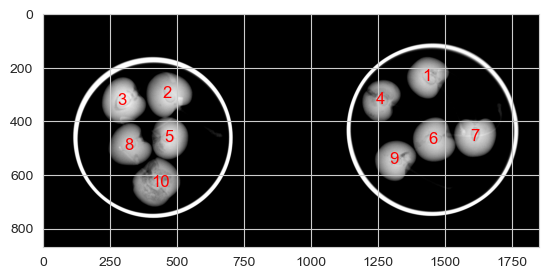

Basic Int-Features:
[[ 0.59739056  0.14819984  2.12642565 -0.50826831  1.18819712  0.39040548]
 [ 0.62131452  0.16506976  2.04934173 -0.36132518  1.23604963  0.39178463]
 [ 0.66004661  0.17441391  2.2211096  -0.48256721  1.31336643  0.39451446]
 [ 0.54163944  0.12833473  2.17818128 -0.40419511  1.07634248  0.39281639]
 [ 0.60635011  0.16708408  1.8770787  -0.30094146  1.2061969   0.39148759]
 [ 0.59985552  0.14920149  2.0971993  -0.46947001  1.19339674  0.38970238]
 [ 0.62940518  0.15627818  2.237108   -0.5712702   1.25128677  0.39471539]
 [ 0.57040464  0.14258148  1.99550043 -0.36771758  1.13469963  0.39402639]
 [ 0.58918589  0.14735042  2.05863315 -0.43281481  1.17143265  0.39232347]
 [ 0.53213398  0.11746102  2.42283358 -0.39637664  1.05840667  0.39298555]]


In [3]:
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = plt.imread('N0001_0004b.png')
implot = plt.imshow(img,cmap='gray')
R      = img>0.27     # segmentation
L      = label(R)     # labeling
n      = np.max(L)    # number of segmented regions
t      = 0
T      = np.zeros((n,6))
for i in range(n):
    R = (L == i)*1    # binary image of object i
    f = basicgeo(R)
    area = f[4]
    # recognition of fruits according to the size
    if area>14000 and area<21000:
        # extract int features only in the segmented region
        h      = basicint(img,region=R)
        T[t,:] = h
        t = t+1
        ax.text(f[1]-20, f[0]+10, str(t), fontsize=12,color='Red')
plt.show()
F = T[0:t,:]
print('Basic Int-Features:')
print(F)


The basic geometric features are extracted by  function `extract_features` of PyXvis  with parameters `'basicint'`, `img=img`, and `bw=R`, where `img` is the original X-ray image and `R` is the binary image that indicates the pixels where the intensity features are extracted.

# Example 2: Defect detection using contrast features

In this example, we show how to detect small defects in an X-ray image of a casting image using area and contrast features. We follow the general block-diagram:

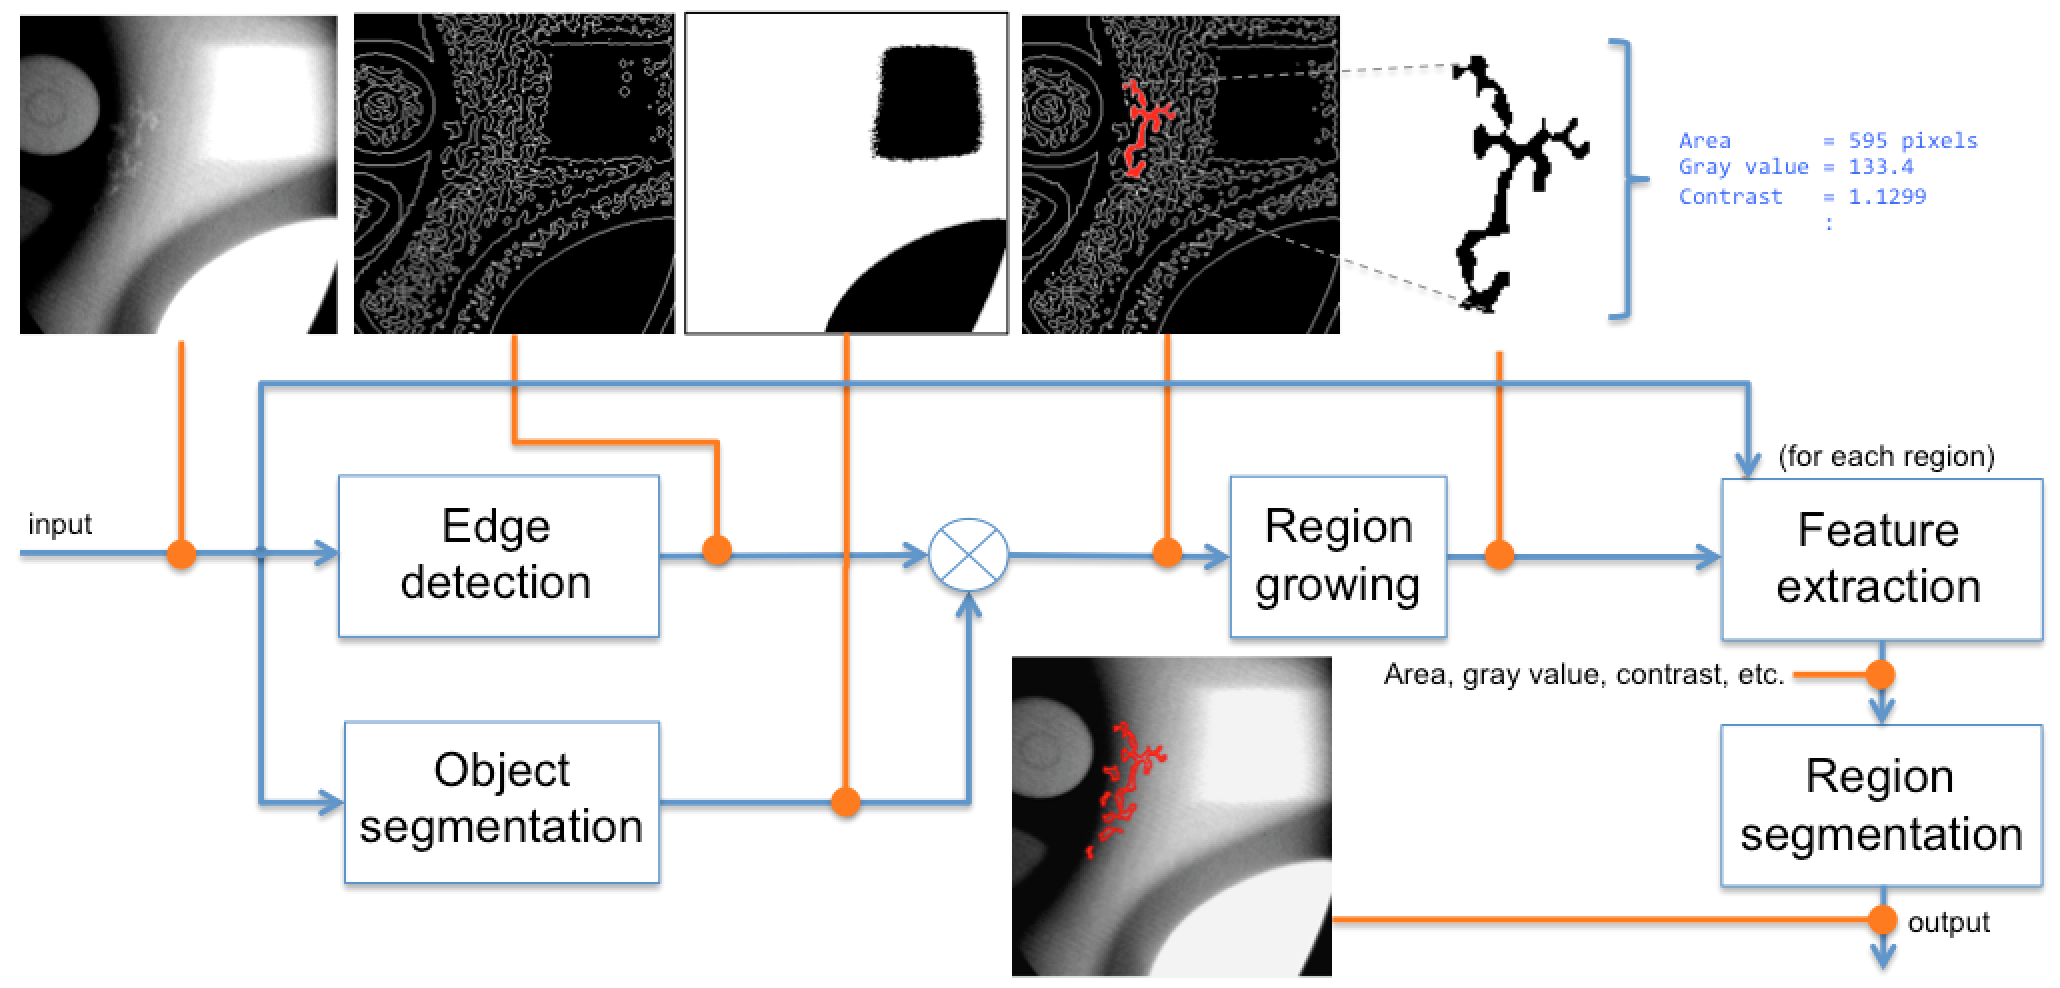

Here, area and contrast features are extracted for each region as defined by enclosed edges. The detection is performed if the size of the region is between some thresholds and the contrast is high enough.

contrast features:
[1.6812865497076022, 0.4567116759332804, 0.9862967351938596, 2.054804667656325, 1.9169226121820626]
area = 29 pixels


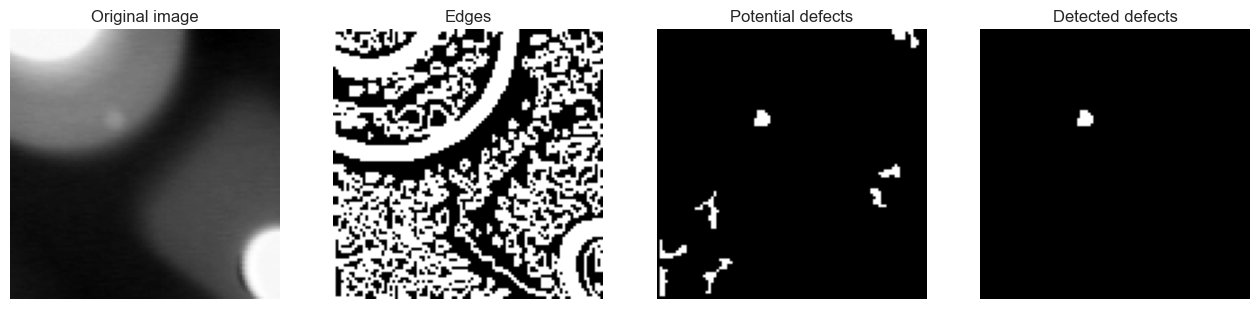

In [4]:
img    = plt.imread('small_wheel.png')  # input image with a defect
(N,M)  = img.shape
e      = gradlog(img,1.25,4/250)
L      = label(~e)         # labeling of objects
n      = np.max(L)         # number of detected objects

K1     = np.zeros((N,M), dtype=bool)
K2     = np.zeros((N,M), dtype=bool)
# Analysis of each segmented object
for i in range(n):
    R = (L == i)*1                             # binary image of object i
    f = basicgeo(R)  # feature extraction for object i
    area = f[4]
    # recognition of potential defects according to the size
    if area>20 and area<40:
        K1 = np.bitwise_or(K1,R)
        i0 = int(round(f[0]))
        j0 = int(round(f[1]))
        h  = int(round(f[2]/2))
        w  = int(round(f[3]/2))
        i1 = max(i0-h,0)
        j1 = max(j0-w,0)
        i2 = min(i0+h,N-1)
        j2 = min(j0+w,M-1)
        I  = img[i1:i2,j1:j2]
        bw  = R[i1:i2,j1:j2]
        x  = contrast(I,region=bw)
        if x[3]>1.5:
            print('contrast features:')
            print(x)
            print('area = '+str(area)+' pixels')
            K2 = np.bitwise_or(K2,R)

fig, ax = plt.subplots(1, 4, figsize=(16, 8))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(e, cmap='gray')
ax[1].set_title('Edges')
ax[1].axis('off')
ax[2].imshow(K1, cmap='gray')
ax[2].set_title('Potential defects')
ax[2].axis('off')
ax[3].imshow(K2, cmap='gray')
ax[3].set_title('Detected defects')
ax[3].axis('off')
plt.show()



# Example 3: Crossing line profiles (CLP)
In this example, we show how to detect a very small casting defect that is located at the edge of a regular structure using area and CLP features. We follow the general block-diagram shown in previous example. That is area and contrast features are extracted for each region defined by enclosed edges. The detection is performed in two steps: i) we detect *potential defects*, i.e, regions that are enclosed by edges that have a size between some thresholds, and ii) we select from the potential defects those regions that have a CLP feature high enough. CLP feature is extracted from a window of the image that contains the potential defect in the middle.



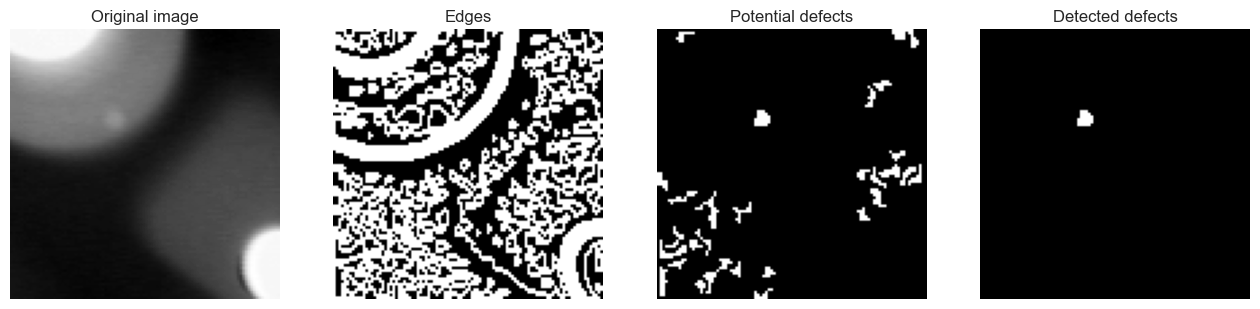

In [5]:
img    = plt.imread('small_wheel.png')  # input image with a defect
(N,M)  = img.shape
e      = gradlog(img,1.25,4/250)
L      = label(~e)         # labeling of objects
n      = np.max(L)         # number of detected objects

K1     = np.zeros((N,M), dtype=bool)
K2     = np.zeros((N,M), dtype=bool)

# Analysis of each segmented object
for i in range(n):
    R = L == i                                # binary image of object i
    f = basicgeo(R*1)  # feature extraction for object i
    area = f[4]

    # recognition of potential defects according to the size
    if area > 10 and area < 40:
        K1 = np.bitwise_or(K1,R)
        i0 = int(round(f[0]))
        j0 = int(round(f[1]))
        h  = int(round(f[2]/2))
        w  = int(round(f[3]/2))
        i1 = max(i0-h,0)
        j1 = max(j0-w,0)
        i2 = min(i0+h,N-1)
        j2 = min(j0+w,M-1)
        I  = img[i1:i2,j1:j2]
        x  = clp(img=I)
        if x[5]>0.4:
            K2 = np.bitwise_or(K2,R)

fig, ax = plt.subplots(1, 4, figsize=(16, 8))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(e, cmap='gray')
ax[1].set_title('Edges')
ax[1].axis('off')
ax[2].imshow(K1, cmap='gray')
ax[2].set_title('Potential defects')
ax[2].axis('off')
ax[3].imshow(K2, cmap='gray')
ax[3].set_title('Detected defects')
ax[3].axis('off')
plt.show()


In this example, the edges are detected using command `gradlog`, that computes the logical "OR" of edge detection using LoG and edge detection by thresholding the gradient. The contrast features are extracted using command `'clp'` with `img=I`, where `I` is an image that contains the potential defects in the middle.  In this example we use features $F_1$ of CLP.

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).